In [178]:
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA

from skimage.feature import hog
from skimage import data, exposure
from skimage.exposure import rescale_intensity
from skimage.util import invert
from skimage.morphology import disk, square, erosion, dilation, area_closing, remove_small_objects

In [92]:
# first data, read CSV + image
path = '../../Data/'
f_img = cv2.imread(path + 'ex01.jpg')
gray_f_img = cv2.cvtColor(f_img, cv2.COLOR_BGR2GRAY)
f_gt = pd.read_csv(path + 'ex01.csv', header=None)

In [93]:
def plot_img(img, gt, title):
    xs = list(gt[0])
    ys = list(gt[1])
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    for idx in range(len(xs)):
        j, i = ys[idx], xs[idx]
        plt.scatter(j, i, color='r')
    plt.show()

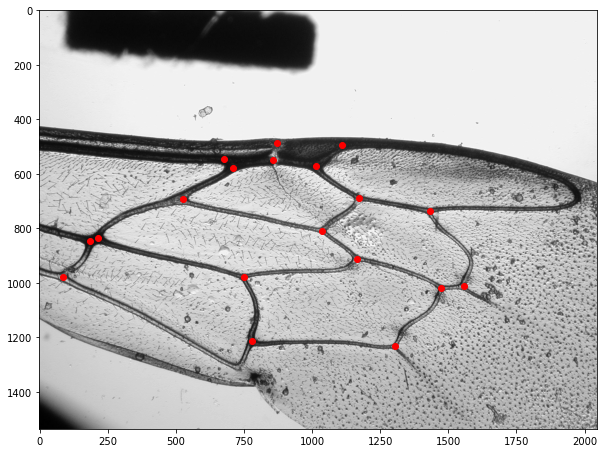

In [94]:
plot_img(gray_f_img, f_gt, '')

In [98]:
def preprocess_img(img, f_gt, display=False):
    '''
    Preprocess the input image with morphology
    '''
    # Rescale the intensity
    p1, p2 = np.percentile(gray_f_img, (10, 98))
    gray_img_rescale = rescale_intensity(img, in_range=(p1, p2))

    if display:
        plt.imshow(gray_img_rescale, cmap='gray')
        plt.show()
        
    # binarisation of the image
    threshold_val = 100
    ret, img = cv2.threshold(gray_img_rescale, threshold_val, 255, 0)

    if display:
        plt.imshow(img, cmap='gray')
        plt.show()
        
    # remove small object from the image with morphology func
    img = img > 0
    res = remove_small_objects(invert(img), min_size=400)
    
    if display:
        plt.imshow(invert(res), cmap='gray')
        plt.show()
        plot_img(invert(res), f_gt, '')
        plt.show()
    
    return invert(res)

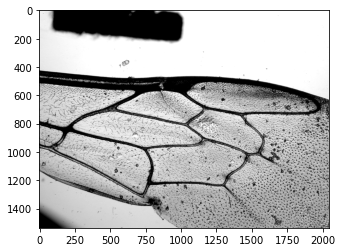

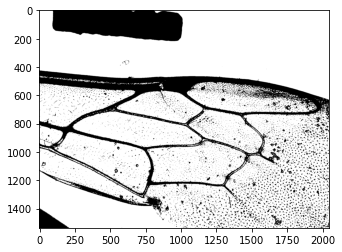

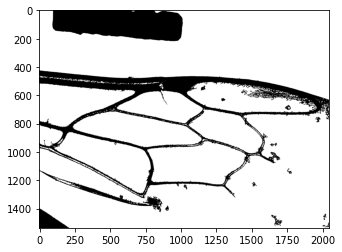

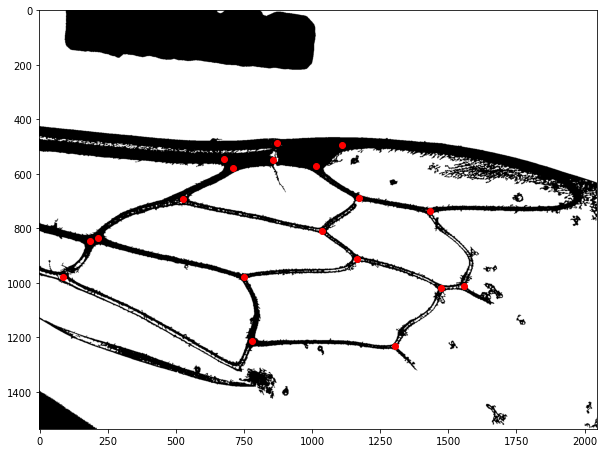

In [99]:
processed_img = preprocess_img(gray_f_img, f_gt, display=True)

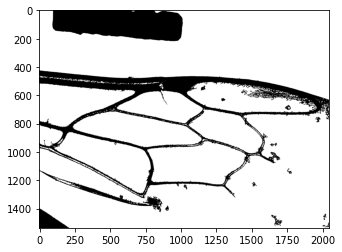

In [103]:
plt.imshow(processed_img, cmap='gray')

In [104]:
def get_hog_intersect_data(img, f_gt, w_radius=128, display=False):
    '''
    Get the HOG feature vector for all the intersections of one image
    '''
    img = img.astype(np.float32)

    # padd img in the case points are close to the borders
    img_padded = np.pad(img, \
                        pad_width=((w_radius,), (w_radius,)), \
                        mode='minimum')
    index_rows = list(f_gt[0])
    index_cols = list(f_gt[1])
    m = len(index_rows)

    features = []

    for i in range(m):
        idx_row, idx_col = int(index_rows[i]), int(index_cols[i])

        # because we have padded the image
        idx_row += w_radius
        idx_col += w_radius

        img_window = img_padded[idx_row-w_radius:idx_row+w_radius, idx_col-w_radius:idx_col+w_radius]

        # TODO add data augmentation
    
        fd, hog_image = hog(img_window, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True)

        features.append(fd)

        if display:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

            ax1.axis('off')
            ax1.imshow(img_window, cmap=plt.cm.gray)
            ax1.set_title('Input image')

            # Rescale histogram for better display
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

            ax2.axis('off')
            ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
            ax2.set_title('Histogram of Oriented Gradients')
            plt.show()

    return np.array(features)

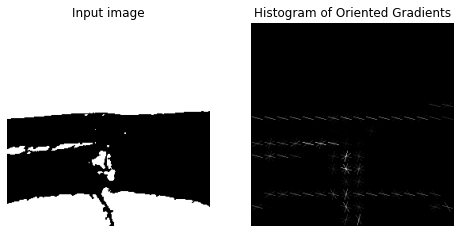

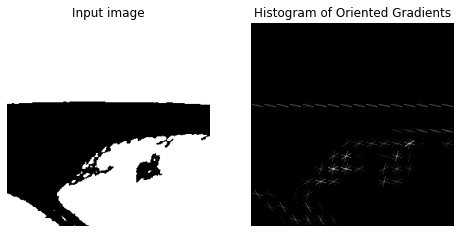

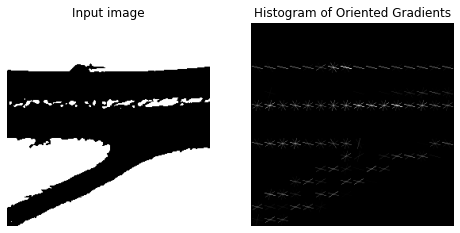

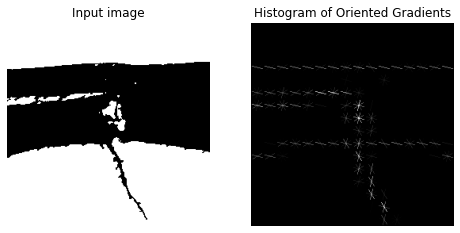

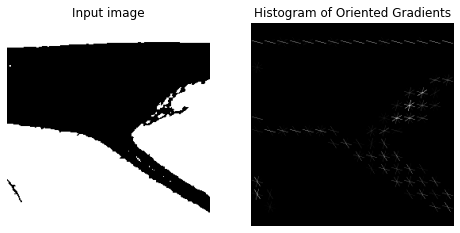

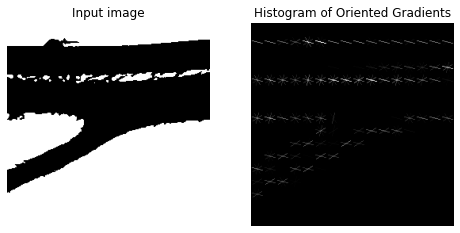

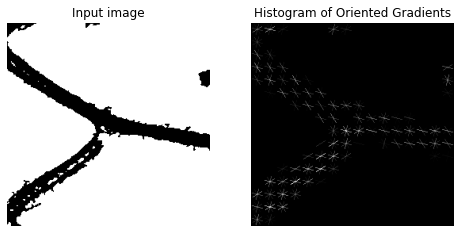

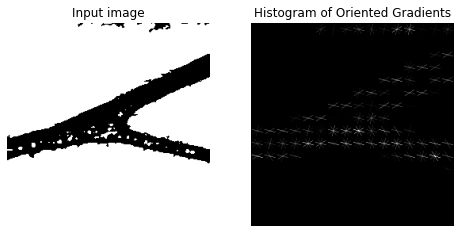

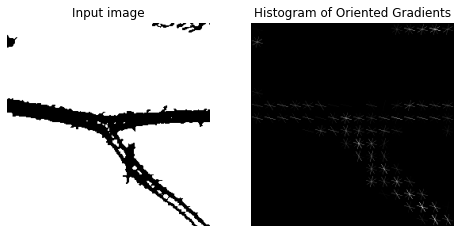

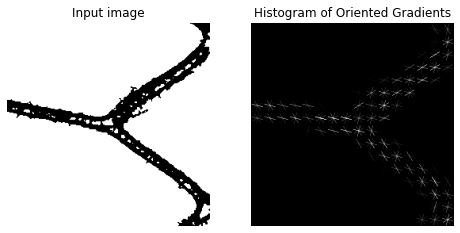

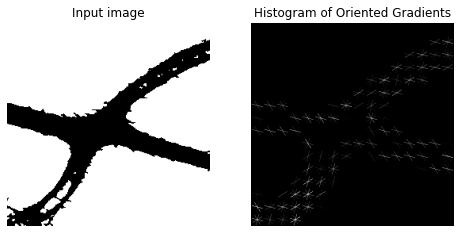

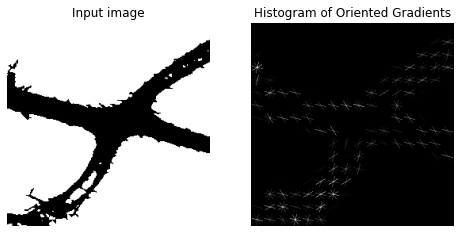

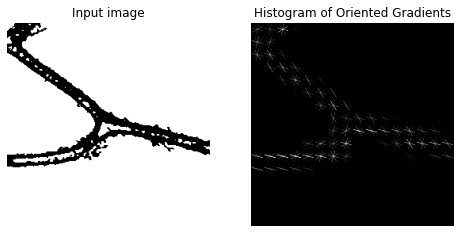

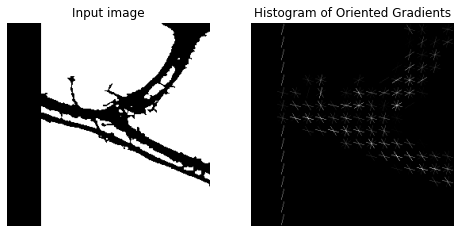

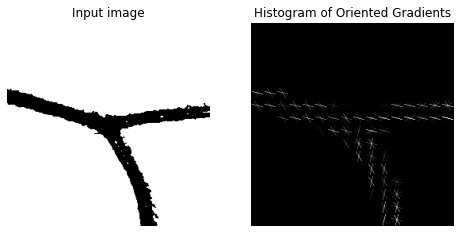

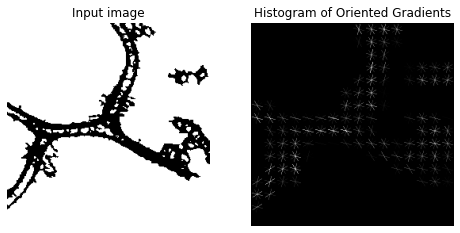

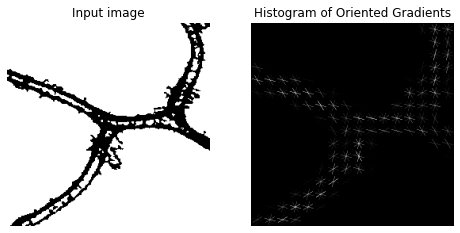

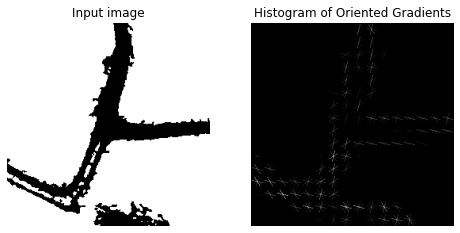

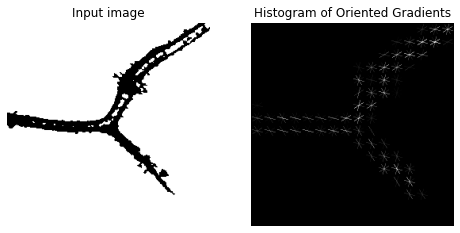

(19, 2048)

In [105]:
features = get_hog_intersect_data(processed_img, f_gt, display=True)
features.shape

In [126]:
def build_dataset(data_path, display=False):
    '''
    Extract features for all images except one that we keep for tests
    '''
    data = []
    for file in glob.glob(data_path + '*.jpg'):
        print("Loading " + file)
        # get label name
        file_name = file.split('.')[-2].split('/')[-1]
        label_file_name = data_path + file_name + '.csv'

        # read img and label
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gt = pd.read_csv(label_file_name, header=None)

        if display:
            img_name = file.split('/')[-1]
            plot_img(gray_img, gt, img_name)
            
        processed_gray_img = preprocess_img(gray_img, gt, display=False)
        features = get_hog_intersect_data(processed_gray_img, gt, w_radius=128, display=False)
        data.append(features)
            
    return np.array(np.vstack(data))

In [163]:
features_data = build_dataset('../../Data/')
features_data.shape

Loading ../../Data/ex03.jpg
Loading ../../Data/ex05.jpg
Loading ../../Data/ex04.jpg
Loading ../../Data/ex02.jpg
Loading ../../Data/ex01.jpg


(108, 2048)

In [164]:
features_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [189]:
# Need to reduce dimensions

pca = PCA(n_components=100)
pca.fit(features_data)
print("Explained variance percentage: {}".format(pca.explained_variance_ratio_.sum()))

reduced_features_data = pca.transform(features_data)
reduced_features_data.shape

Explained variance percentage: 0.9999999999999999


(108, 100)